<h1><center>Laboratorio 6: La desperación de Mr. Lepin 🐼</center></h1>

<center><strong>MDS7202: Laboratorio de Programación Científica para Ciencia de Datos</strong></center>

### Cuerpo Docente:

- Profesor: Matías Rojas y Mauricio Araneda
- Auxiliar: Ignacio Meza D.
- Ayudante: Rodrigo Guerra

### Equipo: SUPER IMPORTANTE - notebooks sin nombre no serán revisados

- Nombre de alumno 1: Cristóbal Alcázar
- Nombre de alumno 2: Gianina Salomó


### **Link de repositorio de GitHub:** `https://github.com/alcazar90/sci-prog-lab`

### Indice 

1. [Temas a tratar](#Temas-a-tratar:)
3. [Descripcción del laboratorio](#Descripción-del-laboratorio.)
4. [Desarrollo](#Desarrollo)

# Temas a tratar

- Aplicar Pandas para obtener características de un DataFrame.
- Aplicar Pipelines.
- Aplicar Clusters sobre un conjunto de datos.

## Reglas:

- Fecha de entrega: 09/06/2021
- **Grupos de 2 personas**
- **Ausentes** deberán realizar la actividad solos. 
- Cualquier duda fuera del horario de clases al foro. Mensajes al equipo docente serán respondidos por este medio.
- Prohibidas las copias. 
- Pueden usar cualquer matrial del curso que estimen conveniente.
- Código que no se pueda ejecutar, no será revisado.

### Objetivos principales del laboratorio

- Comprender y aprovechar las ventajas que nos ofrece la librería `pandas` con respecto a trabajar en Python 'puro'.
- Crear nuevas características para entrenar un modelo de clustering.
- Comprender como aplicar pipelines de Scikit-Learn para generar procesos más limpios.

El laboratorio deberá ser desarrollado sin el uso indiscriminado de iteradores nativos de python (aka "for", "while"). La idea es que aprendan a exprimir al máximo las funciones optimizadas que nos entrega `numpy`, las cuales vale mencionar, son bastante más eficientes que los iteradores nativos sobre arreglos (*o tensores*).

## Descripción del laboratorio.

### Importamos librerias utiles 😸

In [ ]:
%%capture
# Libreria Core del lab.
import numpy as np
import pandas as pd
import datetime
from IPython.display import HTML

# Libreria para plotear (En colab esta desactualizado plotly)
!pip install --upgrade plotly
import plotly.express as px
import plotly.graph_objects as go

# Librerias utiles
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer

In [ ]:
# Si usted está utilizando Colabolatory le puede ser útil este código para cargar los archivos.
try:
    from google.colab import drive
    drive.mount("/content/drive")
    path = 'Dirección donde tiene los archivos en el Drive'
except: 
    print('Ignorando conexión drive-colab')

Ignorando conexión drive-colab


# Segmentación de Clientes en Tienda de Retail 🛍️

<p align="center">
  <img width=300 src="https://s1.eestatic.com/2018/04/14/social/la_jungla_-_social_299733421_73842361_854x640.jpg">
</p>

## 1.1 Cargar Dataset

Mr. Lepin, en una nueva reunión, le cuenta a ud y su equipo que los resultados derivados del análisis exploratorio de dato presentaron una gran utilidad para la empresa y que tiene un gran entusiasmo por continuar trabajando con ustedes.
Es por esto, que Mr. Lepin les pide que cargue y visualicen algunas de las filas que componen el Dataset.
A continuación un extracto de lo parlamentado en la reunión:

    - Usted: Es un gran logro para nuestro equipo que usted haya encontrado excelente el EDA. ¿Qué tiene en mente ahora?
    - Mr. Lepin: Resulta que hace algún tiempo, mientras tomaba un mojito en una reunión de gerentes en Panamá, oí a un *chato* acerca de **LRMFP**, que es un modelo que permite personificar a los clientes a través de la farbicación de distintos atributos que describen a los clientes. Lo encontré es-tu-pendo ñatito. 
    - Usted: Ehh bueno. Investigaremos acerca de este modelo y veremos lo que podemos hacer.

Por ende, su siguiente tarea es calcular **LRMFP** sobre cada cliente y luego hacer un análisis de las características generadas. Para esto, el área de ventas les entrega un nuevo archivo llamado `online_retail_II_cleaned.pickle`, quien posee los datos del DataFrame original limpios y listos para obtener las características solicitadas por Mr. Lepin.

In [ ]:
data_src = 'https://github.com/alcazar90/sci-prog-lab/blob/main/data/online_retail_II_cleaned.pickle?raw=true'
df_retail = pd.read_pickle(data_src)
df_retail = df_retail.astype(
    {
        "Invoice": "category",
        "StockCode": "category",
        "Description": "category",
        "Description": str,
        "Customer ID": "category",
        "Country": "category"
    }
)
df_retail.head()


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


## 1.2 Creación de nuevas Caracteristicas [2 Puntos] 

Como ya se les comento, Mr. Lepin esta interesado en obtener las características **LRMFP**, para esto les señala que estas características se construyen en base a las siguientes definiciones:

- **Length (L)**: Intervalo de tiempo, en días, entre la primera y la última visita del cliente. Mientras mas grande sea el valor, mas fiel es el cliente.
- **Recency (R)**: Indica la actualidad de la interacción de un cliente con la empresa, y da información sobre la tendencia a repetir la compra. Se define como: 
$$Recency(n)=\dfrac{1}{n} \sum^n_{i=1} date\_diff(t_{fecha final}, t_{m-i+1})$$

 Donde $date\_diff$ representa la diferencia en días entre la fecha de finalización del periodo de observación ($t_{fecha final}$), y la fecha de una visita del cliente cercana a $t_{fecha final}$, $t_{m-i+1}; t_{m}$ es la última visita del cliente; y n es el número de visitas recientes del cliente consideradas.

- **Monetary (M)**: El término "monetario" se refiere a la cantidad media de dinero gastada por cada visita del cliente durante el período de observación y refleja la contribución del cliente a los ingresos de la empresa.

- **Frequency (F)**: Se refiere al número total de visitas del cliente durante el periodo de observación. Cuanto mayor sea la frecuencia, mayor será la fidelidad del cliente. 

- **Periodicity (P)**: Representa si los clientes visitan las tiendas con regularidad.

$$Periodicity(n)=std(IVT_1, ..., IVT_n)$$

&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Donde $IVT$ denota el tiempo entre visitas y n representa el número de valores de tiempo entre visitas de un cliente.
 

$$IVT_i=date\_diff(t_{i+1},t)$$

En base a las definiciones señaladas, diseñe una función que permita obtener las características **LRMFP** recibiendo un DataFrame como entrada. Para esto, no estará permitido el uso de iteradores, utilice todas las herramientas que les ofrece `pandas` para realizar esto.

Una referencia que le puede ser útil es el [documento original](https://www.researchgate.net/publication/315979555_LRFMP_model_for_customer_segmentation_in_the_grocery_retail_industry_a_case_study) en donde se propone este método.

**Nota:** Para la $fechafinal$ utilice la fecha máxima del dataset más 1 día.

**Ejemplo de Resultado Esperado:**

| Customer ID | Length | Recency | Frequency | Monetary | Periodicity |
|------------:|-------:|--------:|----------:|---------:|------------:|
|   12346.0   |    294 |      67 |        46 |   -64.68 |        37.0 |
|   12347.0   |     37 |       3 |        71 |  1323.32 |         0.0 |
|   12349.0   |    327 |      43 |       107 |  2646.99 |        78.0 |
|   12352.0   |     16 |      11 |        18 |   343.80 |         0.0 |
|   12356.0   |     44 |      16 |        84 |  3562.25 |        12.0 |

**Respuesta**

Se crea la función solicitada, considerando n=3 para el caso de Recency, y 1 grado de libertad para Periodicity. Con esto se obtiene 2.221 registros nulos para Periodicity.

In [ ]:
def custom_features(dataframe_in):
  # Se obtiene Length, Recency, Frequency; Estos son los campos
  # que se obtienen al agrupar solo por Customer ID
  agg_customer_id = dataframe_in.groupby(
      ["Customer ID"], observed=True
  ).agg(
      Length = (
          "InvoiceDate",
          lambda x: (x.max() - x.min()).days
      ),
      Recency = (
          "InvoiceDate",
          lambda x: np.mean([
              (dataframe_in["InvoiceDate"].max() + pd.Timedelta(days=1)) - i
              for i in list(sorted(set(x)))[-3:] # Se considera n = 3
          ]).days
      ),
      Frequency = (
          "Invoice", pd.Series.nunique
      )
  ).reset_index()

  # Se obtiene Monetary, que depende de la agrupación por Cliente-Visita.
  # Se considera cada visita como una boleta diferente (campo Invoice)
  agg_customer_date = df_retail.assign(
      money = df_retail["Price"] * df_retail["Quantity"]
  ).groupby(["Customer ID", "Invoice"], observed=True).agg(
      Monetary = ("money", "mean")
  ).reset_index().drop(
      columns="Invoice"
  ).groupby("Customer ID").agg({
      "Monetary": "mean"
  }).round(2).reset_index()

  # Se obtiene Periodicity, para lo cual se considera diferencias de fechas
  # entre visitas (campo Invoice)
  # Si el cliente tiene menos de 3 visitas, no se puede obtener su Periodicity
  customer_invoice_unique = df_retail[
      ["Customer ID", "InvoiceDate", "Invoice"]
  ].drop_duplicates().groupby(
      "Customer ID"
  ).agg(
      Periodicity = (
          "InvoiceDate",
          lambda x: pd.Series.diff(x).std().days # 1 grado de libertad
      )
  ).reset_index()

  assert agg_customer_id.shape[0] == \
    agg_customer_date.shape[0] == customer_invoice_unique.shape[0]

  return pd.merge(
      pd.merge(
          agg_customer_id,
          agg_customer_date,
          how="left"
      ),
      customer_invoice_unique,
      how="left"
  ).sort_values(
      by=["Customer ID"]
  ).reset_index(drop=True)

In [ ]:
df_features = custom_features(df_retail)
df_features.head()

,Customer ID,Length,Recency,Frequency,Monetary,Periodicity
0,12346.0,196,256,11,19.67,36.0
1,12347.0,37,21,2,19.12,NaN
2,12348.0,0,74,1,11.11,NaN
3,12349.0,181,158,3,82.91,101.0
4,12351.0,0,11,1,14.33,NaN


In [ ]:
df_features.isna().sum()

Customer ID       0
Length            0
Recency           0
Frequency         0
Monetary          0
Periodicity    2225
dtype: int64

## 1.3 Pipelines 👷

Finalmente *Don Mora* le pregunta si seria posible realizar un pipeline para realizar una segmentación de los clientes con los nuevos datos generados, a lo que usted responde que **sí** y propone la utilización de k-means para la segmentación.

A continuación siga los pasos requeridos para obtener la segmentación de clientes.

### 1.3.1 Estandarizar Caracteristicas [0.5 puntos]

Construya una clase llamada ``MinMax()`` utilizando ``BaseEstimator`` y ``TransformerMixin`` para realizar una transformación de cada una de las columnas de un DataFrame utilizando ``ColumnTransformer()`` más tarde (tome como referencia el siguiente [enlace](https://sklearn-template.readthedocs.io/en/latest/user_guide.html#transformer)).


 Para esto considere que Min-Max escaler queda dada por la ecuación:

$$MinMax = \dfrac{x-min(x)}{max(x) - min(x)}$$

Con esto buscamos que los valores que componen a las columnas se muevan en el rango de valores $[0, 1]$.

**Respuesta:**

Se crea la clase `MinMax` que en su `fit` almacena los `min` y `max` de los datos de entrada, y en su `transform` los utiliza para aplicar la estandarización en los datos recibidos.

In [ ]:
class MinMax(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
      self.min = X.min()
      self.max = X.max()
      return self

    def transform(self, X, y=None):
      return (X - self.min) / (self.max - self.min)

### 1.3.2 `T-SNA` Pipeline [1.0 puntos]

Para comenzar introduciéndose en el uso de pipeline, decide probar realizando un pipeline enfocado en la reducción de dimensionalidad y así hacer no decepcionar a Mr. Lepin con la clusterización del modelo. 

Configure un pipeline utilizando el algoritmo `T-SNE` sobre los datos **LRMFP**, donde, para la realización del pipeline considera los siguientes pasos:

1. Como primer paso obtenga las características **LRMFP** desde el DataFrame ``df_retail_II_cleaned.pickle`` utilizando la función ``custom_features`` creada anteriormente, junto a ``FunctionTransformer()``. Considere esto como el primer paso de su pipeline.
2. En segundo lugar usando ``ColumnTransformer()`` aplique el MinxMax scaler creado por usted sobre todas las columnas generadas en el paso anterior. 
3. Finalmente, aplique un último paso donde obtiene las 2 componentes más relevantes utilizando el algoritmo T-sne de sckit-learn.

Tras aplicar las transformaciones sobre el dataset **LRMFP**, gráfique las componentes obtenidas en la reducción de dimensionalidad.

**Respuesta:**

Se realiza primero una implementación según lo solicitado, para lo cual se omite la columna Periodicity, ya que contiene datos nulos.

Luego se hace una implementación que agrega un nuevo paso de `ColumnTransformer` para agregar la imputación de nulos por el valor máximo obtenido de Periodicity. Esto ya que se considera que los clientes con una cantidad de visitas bajas tienen baja regularidad, y por ende alto valor de Periodicity.

In [ ]:
pipeline = Pipeline([
    # Aplicar función para crear features sobre dataframe completo
    ("custom_features", FunctionTransformer(custom_features)),
    # Aplicar min-max scale sobre columnas específicas del dataframe
    ("column_transforms", ColumnTransformer(
        transformers=[
            ("min_max", MinMax(), [
                'Length', 'Recency', 'Frequency', 'Monetary'
            ])
        ]
      )
    ),
    # Aplicar TSNE
    ("tsne", TSNE(
        n_components=2, random_state=42, init="random", learning_rate=200
      )
    )
]).fit_transform(df_retail)

In [ ]:
df_tsne = pd.DataFrame(
    { "x_tsne": pipeline[:, 0],  "y_tsne": pipeline[:, 1] }
)
px.scatter(df_tsne, x="x_tsne", y="y_tsne")

En esta primera implementación pareciera haber 3 clusters aglomerados, junto con valores dispersos que no se asignan a ningún cluster.

In [ ]:
# Con periodicity
class MaxImputer(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    self.max = pd.DataFrame(X).dropna().max()
    return self

  def transform(self, X, **kwargs):
    return pd.DataFrame(X).fillna(self.max)

pipeline_2 = Pipeline([
    # Aplicar función para crear custom features sobre dataset
    ("custom_features", FunctionTransformer(custom_features)),
    # Aplicar MinMax para escalar columnas 
    ("column_transforms", ColumnTransformer(
        transformers=[
            ("min_max", MinMax(), [
                'Length', 'Recency', 'Frequency', 'Monetary', 'Periodicity'
            ])
        ]
      )
    ),
    # Aplicar sobre Periodicity ([4]) MaxImputer
    ("periodicity_input", ColumnTransformer(
        transformers=[
            ("input_max", MaxImputer(), [4]),
        ]
      )
    ),
    # Aplicar TSNE
    ("tsne", TSNE(
        n_components=2, random_state=42, init="random", learning_rate=200
      )
    )
]).fit_transform(df_retail)

In [ ]:
pipeline_2.shape, df_features.shape

((4314, 2), (4314, 6))

In [ ]:
df_tsne_2 = pd.DataFrame(
    { "x_tsne": pipeline_2[:, 0],  "y_tsne": pipeline_2[:, 1] }
)
px.scatter(df_tsne_2, x="x_tsne", y="y_tsne")

En esta segunda implementación se aprecia 1 cluster aglomerado, junto con valores dispersos.

Con esto se aprecia que los atributos considerados influyen bastante en los clusters generados.

### 1.3.3 Clustering

#### 1.3.3.1 Método del Codo [1 puntos]

Utilizando la clase creada para escalamiento, aplique el método del codo para visualizar cual es el número de clusters que mejor se ajustan a los datos. Realice esto utilizando el algoritmo K-means dentro de un pipeline para un $k \in [1,20]$, donde k representa el número de clusters del k-means. Para la realización de esta sección y la próxima (1.3.3.2), considere los mismos pasos utilizados para el t-sne, pero permutando el algoritmo de reducción de dimensionalidad por k-means.

A través del grafico obtenido, comente y justifique que valor de k escogería para realizar el k-means.

**Respuesta:**

Se implementa el pipeline solicitado, con lo que se repite el proceso completo 20 veces.

In [ ]:
pipelines_km = [
    Pipeline([
        ("custom_features", FunctionTransformer(custom_features)),
        ("column_transforms", ColumnTransformer(
            transformers=[
                ("min_max", MinMax(), [
                    'Length', 'Recency', 'Frequency', 'Monetary', 'Periodicity'
                ])
            ]
          )
        ),
        ("periodicity_input", ColumnTransformer(
            transformers=[
                ("input_max", MaxImputer(), [4]),
            ]
          )
        ),
        ("kmeans", KMeans(n_clusters=i, random_state=42))
    ]).fit(df_retail)
    for i in range(1, 21)
]

In [ ]:
inercias = pd.DataFrame([
    {
        "Inercia": p[3].inertia_,
        "N clusters": i + 1
    }
    for i, p in enumerate(pipelines_km)
])
px.line(inercias, x="N clusters", y="Inercia")

Según lo obtenido por el método del gráfico del codo, la cantidad óptima de clusters es 2, ya que a partir de este punto es que se obtiene una gran disminución de la inercia. También se podría considerar 3 clusters, que es donde se observa el siguiente quiebre (Se aprecia mejor al hacer zoom en esta zona del gráfico, ya que el valor de 1 cluster es tan alto que en escala original no se logra apreciar bien).

A modo de ver otra forma de elección, se realiza un análisis de puntaje de Silouette.

In [ ]:
df_preproc = MaxImputer().fit_transform(custom_features(df_retail))
df_preproc.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



,Customer ID,Length,Recency,Frequency,Monetary,Periodicity
0,12346.0,196,256,11,19.67,36.0
1,12347.0,37,21,2,19.12,255.0
2,12348.0,0,74,1,11.11,255.0
3,12349.0,181,158,3,82.91,101.0
4,12351.0,0,11,1,14.33,255.0


In [ ]:
from sklearn.metrics import silhouette_score

scores = pd.DataFrame([
    {
        "S.Score": silhouette_score(df_preproc, p[3].labels_),
        "N clusters": i + 1
    }
    for i, p in enumerate(pipelines_km[1:])
])

scores.head(20).sort_values(by=["S.Score"], ascending=False)

,S.Score,N clusters
0,0.019385,1
1,-0.015907,2
2,-0.027371,3
3,-0.037084,4
4,-0.041816,5
5,-0.042723,6
7,-0.052193,8
6,-0.059575,7
9,-0.097621,10
8,-0.099515,9


Al explorar los puntajes de Silhouette se observa que solo se tiene un valor positivo (aunque muy cercano a 0). Esto coincide con lo observado al usar TSNE, que mostraba solo 1 cluster.

Por motivos pedagógicos, se decide continuar con la elección de **2 clusters** para los ejercicios siguientes, aunque los datos revelan que para este caso no aplicaría una clusterización.

Otra posibilidad que podría explorar, en otra instancia, sería el de agregar un paso en el pipeline que en lugar de imputar los valores nulos de Periodicity, simplemente los elimine.

#### 1.3.3.2 Segmentación de Clientes con K-Means 🎁 [1 punto]

En base a la elección de k realizada en la sección anterior, utilice este valor escogido y entrene un modelo de K-means utilizando el mismo pipeline de scikit-learn utilizado anteriormente.

Una vez ajustado los datos, genere una tabla con los promedios (o medianas) para cada uno de los atributos, agrupando estos por el clúster que pertenecen. ¿Es posible observar agrupaciones coherentes?, ¿Qué tipo de clientes posee el retail?, Justifique su respuesta y no decepcione a Mr. Lepin.


**Respuesta:**

En lugar de entrenar el pipeline nuevamente, se utiliza la lista de pipelines previamente almacenada, para acceder al pipeline utilizado con 2 clusters de kmeans.

In [ ]:
best_kmeans = pipelines_km[1].named_steps["kmeans"]

Primero se asigna al df con el pre procesamiento aplicado la etiqueta correspondiente a su cluster

In [ ]:
df_preproc["cluster"] = best_kmeans.labels_
df_preproc["cluster"].value_counts()

1    2277
0    2037
Name: cluster, dtype: int64

In [ ]:
df_preproc.head()

,Customer ID,Length,Recency,Frequency,Monetary,Periodicity,cluster
0,12346.0,196,256,11,19.67,36.0,0
1,12347.0,37,21,2,19.12,255.0,1
2,12348.0,0,74,1,11.11,255.0,1
3,12349.0,181,158,3,82.91,101.0,0
4,12351.0,0,11,1,14.33,255.0,1


Luego se explora la media y mediana por cluster

In [ ]:
estadisticos = pd.concat([
    df_preproc.groupby(["cluster"]).mean().assign(Métrica="Media"),
    df_preproc.groupby(["cluster"]).median().assign(Métrica="Mediana")
]).reset_index()

estadisticos

,cluster,Length,Recency,Frequency,Monetary,Periodicity,Métrica
0,0,233.966127,99.133530,7.860579,41.194188,39.442317,Media
1,1,44.450154,150.678524,1.406675,41.696517,253.231445,Media
2,0,245.000000,83.000000,5.000000,19.440000,31.000000,Mediana
3,1,0.000000,139.000000,1.000000,16.970000,255.000000,Mediana


Se agrega una exploración con gráficos para complementar la información obtenida anteriormente.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

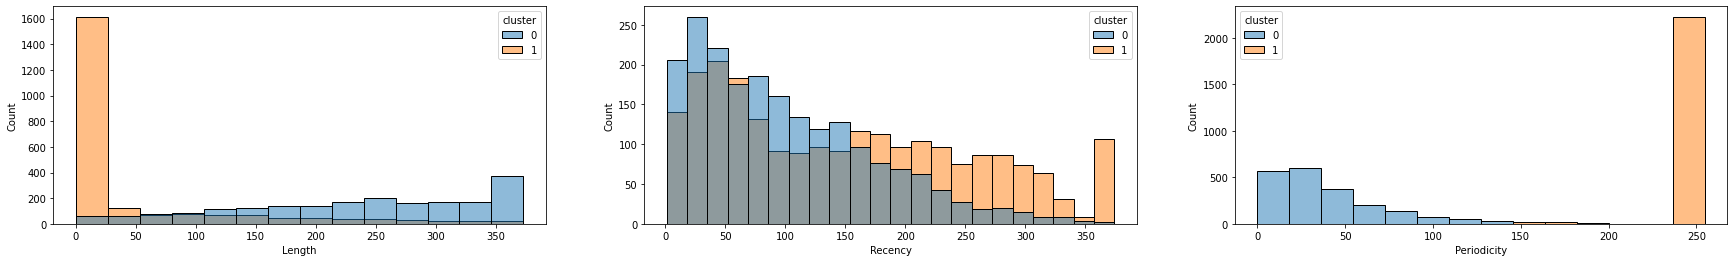

In [ ]:
fig, axes = plt.subplots(1, 3, sharex=False, sharey=False, figsize=(30, 4))
for i, c in enumerate(["Length", "Recency", "Periodicity"]):
  sns.histplot(ax=axes[i], data=df_preproc, x=c, hue="cluster");

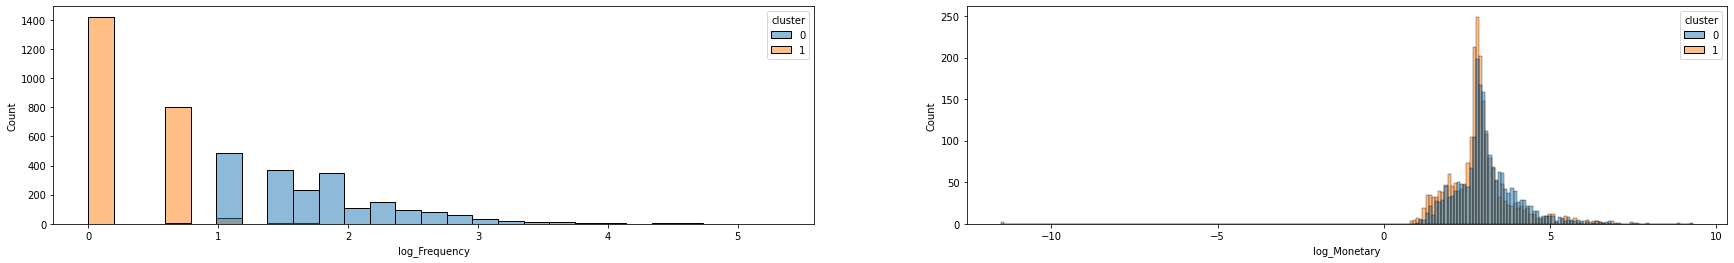

In [ ]:
fig, axes = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(30, 4))
for i, c in enumerate(["Frequency", "Monetary"]):
  name = f"log_{c}"
  df_preproc[name] = np.log(df_preproc[c] + 0.00001)
  sns.histplot(ax=axes[i], data=df_preproc, x=name, hue="cluster");

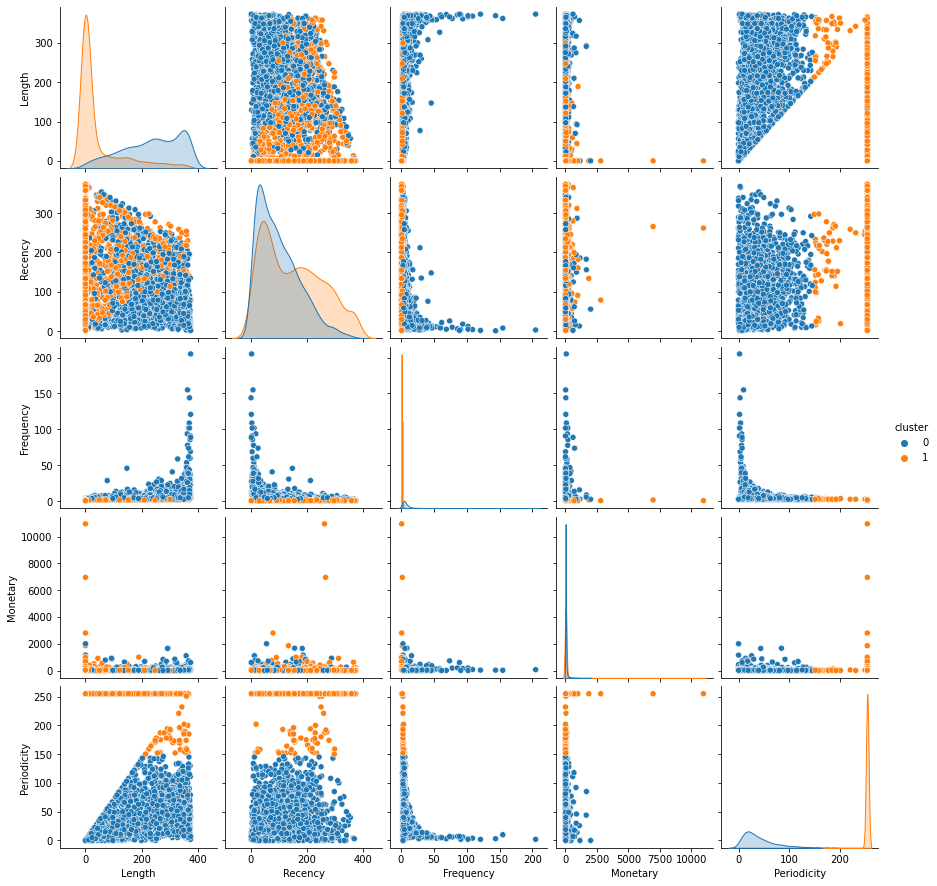

In [ ]:
sns.pairplot(df_preproc[["Length", "Recency", "Frequency", "Monetary", "Periodicity", "cluster"]], hue="cluster");

**¿Es posible observar agrupaciones coherentes?**

Se logra apreciar, sobre todo en los atributos de Frequency, Length y Periodicity, que existe una distribución diferente entre los clientes asignados al cluster 0 y los asignados al cluster 1. En el caso de Recency, también se ve una diferencia a medida que aumenta su valor, y se ve una segmentación clara al hacer el análisis junto con Periodicity. Para el caso de Monetary, la distribución es muy similar en ambos clusters.

- Los clientes del _cluster 0_ tienen **mayor Length** que los clientes del _cluster 1_
- Los clientes del _cluster 0_ tienen **menor Recency** que los clientes del _cluster 1_
- Los clientes del _cluster 0_ tienen **menor Periodicity** que los clientes del _cluster 1_
- Los clientes del _cluster 0_ tienen **mayor Frecuencia** que los clientes del _cluster 1_
- Los clientes del _cluster 0_ tienen **similar Monetary** que los clientes del _cluster 1_

**¿Qué tipo de clientes posee el retail?**

Se encontró 2 tipos de cliente:
- _Clientes premium_: Estos serían los pertenecientes al _cluster 0_ obtenido mediante kmeans. Se caracterizan por ser clientes que han realizado compras durante un largo periodo total, con poca diferencia entre visitas, y alta cantidad de visitas.

- _Clientes regulares_: Estos serían los pertenecientes al _cluster 1_ obtenido mediante kmeans. Se caracterizan por ser clientes que realizaron compras en un tiempo acotado y/o separadas en el tiempo entre sí, y/o que han realizado pocas visitas.

**Respuesta Esperada:**

|         | Length  | Recency   | Frequency | Monetary | Periodicity |       |
|---------|---------|-----------|----------|-------------|-------|-------|
| Cluster |         |           |          |             |       |       |
|    0    |   258.8 |      45.2 |     76.1 |      1107.7 | 107.6 |   449 |
|    1    |    76.1 |     217.6 |     45.5 |       791.7 |  14.1 |   466 |
|    2    |   368.5 |       4.8 |   2715.0 |    226621.6 |   4.2 |     4 |
|    3    |    85.3 |      45.7 |     65.8 |      1047.0 |  10.5 |   987 |
|    4    |   347.2 |      15.9 |   1658.0 |     35829.3 |   8.0 |    25 |
|    5    |   298.0 |      29.8 |    183.8 |      3639.9 |  32.0 |  1188 |

#### 1.3.3.3 Plot de K-Means 📈 [0.5 puntos]



Por último, Mr. Lepin, impaciente de no entender lo que usted intenta explicarle, le solicita que por favor muestre algún resultado "visual" de los grupos encontrados.

Para esto, grafique nuevamente las características encontradas usando `T-SNE` (no calcule de nuevo, simplemente utilice las proyecciones encontradas) y agregue las labels calculadas con kmeans como el argumento `color`.   

Comente: ¿Se separan bien los distintos clusters en la visualización?


**Respuesta:**

In [ ]:
df_preproc["Primer componente TSNE"] = df_tsne_2["x_tsne"]
df_preproc["Segundo componente TSNE"] = df_tsne_2["y_tsne"]
px.scatter(
    df_preproc, x="Primer componente TSNE", y="Segundo componente TSNE",color="cluster",
    hover_data=["Length", "Recency", "Frequency", "Monetary", "Periodicity"],
    title="Proyección a 2 dimensiones de los features de cada cliente por segmento"
)

**¿Se separan bien los distintos clusters en la visualización?**

En términos generales se ve una buena separación, donde los clientes regulares son los que se ubican mayormente en el grupo central (elipse amarilla). Este grupo parece seguir una forma elíptica que se extiende más hacia los lados, ya que alcanza a capturar algunos datos que se encuentran a la izquierda, fuera del elipsoide central.

Los clientes pertenecientes al cluster 0, "clientes premium", se encuentran dispersos alrededor del grupo central, en distintas ubicaciones.

Para complementar el reporte a Mr. Lepin, se puede adjuntar también los histogramas desarrollados en el ítem anterior.

# Conclusión
Eso ha sido todo para el lab de hoy, recuerden que el laboratorio tiene un plazo de entrega de una semana y que **los días de atraso no se pueden utilizar para entregas de lab** solo para tareas. Cualquier duda del laboratorio, no duden en contactarnos por mail o U-cursos.

![Gracias Totales!](https://i.pinimg.com/originals/65/ae/27/65ae270df87c3c4adcea997e48f60852.gif "bruno")


<br>
<center>
<img src="https://i.kym-cdn.com/photos/images/original/001/194/195/b18.png" width=100 height=50 />
</center>
<br>

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=87110296-876e-426f-b91d-aaf681223468' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>